In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
from mistune.plugins.math import math
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataset_base_path = r'E:\PycharmProjects\pythonProject1\X-IIoTID'


In [3]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.preprocessing import LabelEncoder
import re

types = {
    'Date': 'object',
    'Timestamp': 'int64',
    'Scr_IP': 'object',
    'Scr_port': 'uint16',
    'Des_IP': 'object',
    'Des_port': 'uint16',
    'Protocol': 'object',
    'Service': 'object',
    'Duration': 'float32',
    'Scr_bytes': 'int32',
    'Des_bytes': 'int32',
    'Conn_state': 'uint8',
    'missed_bytes': 'uint8',
    'is_syn_only': 'bool',
    'Is_SYN_ACK': 'bool',
    'is_pure_ack': 'bool',
    'is_with_payload': 'bool',
    'FIN or RST': 'bool',
    'Bad_checksum': 'bool',
    'is_SYN_with_RST': 'bool',
    'Scr_pkts': 'int32',
    'Scr_ip_bytes': 'int32',
    'Des_pkts': 'int32',
    'Des_ip_bytes': 'int32',
    'anomaly_alert': 'bool',
    'total_bytes': 'int32',
    'total_packet': 'int32',
    'paket_rate': 'float32',
    'byte_rate': 'float32',
    'Scr_packts_ratio': 'float32',
    'Des_pkts_ratio': 'float32',
    'Scr_bytes_ratio': 'float32',
    'Des_bytes_ratio': 'float32',
    'Avg_user_time': 'float32',
    'Std_user_time': 'float32',
    'Avg_nice_time': 'float32',
    'Std_nice_time': 'float32',
    'Avg_system_time': 'float32',
    'Std_system_time': 'float32',
    'Avg_iowait_time': 'float32',
    'Std_iowait_time': 'float32',
    'Avg_ideal_time': 'float32',
    'Std_ideal_time': 'float32',
    'Avg_tps': 'float32',
    'Std_tps': 'float32',
    'Avg_rtps': 'float32',
    'Std_rtps': 'float32',
    'Avg_wtps': 'float32',
    'Std_wtps': 'float32',
    'Avg_ldavg_1': 'float32',
    'Std_ldavg_1': 'float32',
    'Avg_kbmemused': 'float32',
    'Std_kbmemused': 'float32',
    'Avg_num_Proc/s': 'float32',
    'Std_num_proc/s': 'float32',
    'Avg_num_cswch/s': 'float32',
    'std_num_cswch/s': 'float32',
    'OSSEC_alert': 'uint8',
    'OSSEC_alert_level': 'uint8',
    'Login_attempt': 'uint8',
    'Succesful_login': 'uint8',
    'File_activity': 'uint8',
    'Process_activity': 'uint8',
    'read_write_physical.process': 'uint8',
    'is_privileged': 'uint8',
    'class1': 'object',
    'class2': 'object',
    'class3': 'object'
}


def load_dataset(files, dtypes=None, cols=None):
    # Read the data without enforcing dtypes initially
    df = pd.concat((pd.read_csv(f, usecols=cols, low_memory=False) for f in files))

    # Replace '-' with NaN in all columns
    df = df.replace('-', np.nan)

    # Convert to proper dtypes before cleaning
    if dtypes:
        try:
            for col, dtype in dtypes.items():
                if col in df.columns:
                    if dtype == 'object':
                        df[col] = df[col].astype(str)
                    elif dtype == 'bool':
                        # Identify and replace non-numeric values with NaN
                        non_numeric_values = df[col].apply(lambda x: not isinstance(x, (int, float)) and not re.match(r'^(True|False)$', str(x), re.IGNORECASE))
                        df.loc[non_numeric_values, col] = np.nan
                        # Convert directly to int first before converting to bool
                        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int).astype(bool)
                    else:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error while applying dtypes: {e}")
            return None

    # Identify numeric columns after converting types
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Drop rows with infinite or negative values in numeric columns
    for col in numeric_cols:
        df = df[~((df[col] == np.inf) | (df[col] == -np.inf) | (df[col] < 0))]

    # Convert boolean-like columns to integers (0 or 1)
    for col in df.columns:
        if df[col].dtype == 'bool' or (df[col].dtype == 'object' and df[col].astype(str).str.lower().isin(['true', 'false']).any()):
            try:
                # Identify and replace non-numeric values with NaN
                non_numeric_values = df[col].apply(lambda x: not isinstance(x, (int, float)) and not re.match(r'^(True|False)$', str(x), re.IGNORECASE))
                df.loc[non_numeric_values, col] = np.nan
                # Convert to numeric, and handle NaN values again to ensure correct conversion
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
            except Exception as e:
                print(f"Error converting column '{col}': {e}")
                continue

    # Specific handling for 'anomaly_alert'
    if 'anomaly_alert' in df.columns:
        try:
            # Apply same cleaning to 'anomaly_alert'
            non_numeric_values = df['anomaly_alert'].apply(lambda x: not isinstance(x, (int, float)) and not re.match(r'^(True|False)$', str(x), re.IGNORECASE))
            df.loc[non_numeric_values, 'anomaly_alert'] = np.nan
            df['anomaly_alert'] = pd.to_numeric(df['anomaly_alert'], errors='coerce').fillna(0).astype(int)
        except Exception as e:
            print(f"Error while converting column anomaly_alert: {e}")

    # Label encode Protocol and Service columns
    for col in ['Protocol', 'Service']:
        if col in df.columns:
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

    return df


In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
df

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a

,Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,...,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,class1,class2,class3
0,9/01/2020,1.578541e+09,192.168.2.199,49278.0,192.168.2.10,80.0,1,4,0.673690,13437.0,...,5,0,0,0,0,0,0,Scanning_vulnerability,Reconnaissance,Attack
1,13/01/2020,1.578872e+09,10.0.1.5,39769.0,131.236.3.92,53.0,2,2,0.000083,78.0,...,0,0,0,0,0,0,0,Normal,Normal,Normal
2,9/01/2020,1.578522e+09,172.24.1.80,59050.0,172.24.1.1,53.0,2,2,0.000132,38.0,...,0,0,0,0,0,0,0,Normal,Normal,Normal
3,27/02/2020,1.582758e+09,192.168.2.196,37966.0,192.168.2.10,1880.0,1,16,9.378481,1121.0,...,0,1,1,1,1,1,1,Normal,Normal,Normal
5,31/01/2020,1.580453e+09,192.168.10.155,50502.0,192.168.2.10,80.0,1,4,5.153928,460.0,...,0,0,0,0,0,1,0,Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820827,15/01/2020,1.579041e+09,192.168.2.199,51292.0,192.168.2.10,80.0,1,4,0.205832,127.0,...,5,0,0,0,0,0,0,BruteForce,Weaponization,Attack
820830,22/01/2020,1.579654e+09,172.24.1.80,45913.0,172.24.1.1,1880.0,1,16,63.290477,0.0,...,0,0,0,0,0,0,0,Normal,Normal,Normal
820831,15/01/2020,1.579064e+09,192.168.10.153,53252.0,192.168.2.10,80.0,1,4,14.787547,26091.0,...,0,0,0,0,0,1,0,Normal,Normal,Normal
820832,7/01/2020,1.578375e+09,192.168.2.199,44451.0,192.168.2.10,19315.0,1,11,0.000011,0.0,...,0,0,0,0,0,0,0,Generic_scanning,Reconnaissance,Attack


In [5]:
print(df)


              Date     Timestamp          Scr_IP  Scr_port        Des_IP  \
0        9/01/2020  1.578541e+09   192.168.2.199   49278.0  192.168.2.10   
1       13/01/2020  1.578872e+09        10.0.1.5   39769.0  131.236.3.92   
2        9/01/2020  1.578522e+09     172.24.1.80   59050.0    172.24.1.1   
3       27/02/2020  1.582758e+09   192.168.2.196   37966.0  192.168.2.10   
5       31/01/2020  1.580453e+09  192.168.10.155   50502.0  192.168.2.10   
...            ...           ...             ...       ...           ...   
820827  15/01/2020  1.579041e+09   192.168.2.199   51292.0  192.168.2.10   
820830  22/01/2020  1.579654e+09     172.24.1.80   45913.0    172.24.1.1   
820831  15/01/2020  1.579064e+09  192.168.10.153   53252.0  192.168.2.10   
820832   7/01/2020  1.578375e+09   192.168.2.199   44451.0  192.168.2.10   
820833  16/12/2019  1.576459e+09        10.0.1.5   33903.0  131.236.3.92   

        Des_port  Protocol  Service   Duration  Scr_bytes  ...  \
0           80.0     

In [6]:
import socket
import struct
import pandas as pd

def ip_to_int(ip_address):
    try:
        return struct.unpack("!I", socket.inet_aton(ip_address))[0]
    except socket.error:
        return None



df['Source IP (int)'] = df['Scr_IP'].apply(ip_to_int)
df['Destination IP (int)'] = df['Des_IP'].apply(ip_to_int)

print(df)


              Date     Timestamp          Scr_IP  Scr_port        Des_IP  \
0        9/01/2020  1.578541e+09   192.168.2.199   49278.0  192.168.2.10   
1       13/01/2020  1.578872e+09        10.0.1.5   39769.0  131.236.3.92   
2        9/01/2020  1.578522e+09     172.24.1.80   59050.0    172.24.1.1   
3       27/02/2020  1.582758e+09   192.168.2.196   37966.0  192.168.2.10   
5       31/01/2020  1.580453e+09  192.168.10.155   50502.0  192.168.2.10   
...            ...           ...             ...       ...           ...   
820827  15/01/2020  1.579041e+09   192.168.2.199   51292.0  192.168.2.10   
820830  22/01/2020  1.579654e+09     172.24.1.80   45913.0    172.24.1.1   
820831  15/01/2020  1.579064e+09  192.168.10.153   53252.0  192.168.2.10   
820832   7/01/2020  1.578375e+09   192.168.2.199   44451.0  192.168.2.10   
820833  16/12/2019  1.576459e+09        10.0.1.5   33903.0  131.236.3.92   

        Des_port  Protocol  Service   Duration  Scr_bytes  ...  \
0           80.0     

In [7]:
X = df.drop(columns=['class1','class2','class3','Scr_IP','Des_IP','Date'])
y = df[['class3']]

In [8]:
import numpy as np
import pandas as pd

combined = pd.concat([X, y], axis=1)

# حذف الأسطر التي تحتوي على NaN
combined.dropna(inplace=True)

numeric_cols = combined.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    combined = combined[~((combined[col] == np.inf) | (combined[col] == -np.inf))]

X = combined[X.columns]
y = combined[y.columns]

print(f"الشكل الجديد لـ X: {X.shape}")
print(f"الشكل الجديد لـ y: {y.shape}")


الشكل الجديد لـ X: (595628, 64)
الشكل الجديد لـ y: (595628, 1)


In [9]:
y.class3.value_counts()

class3
Normal    336210
Attack    259418
Name: count, dtype: int64

In [10]:
X

,Timestamp,Scr_port,Des_port,Protocol,Service,Duration,Scr_bytes,Des_bytes,Conn_state,missed_bytes,...,OSSEC_alert,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,Source IP (int),Destination IP (int)
0,1.578541e+09,49278.0,80.0,1,4,0.673690,13437.0,34924.0,1,0.0,...,1,5,0,0,0,0,0,0,3.232236e+09,3.232236e+09
1,1.578872e+09,39769.0,53.0,2,2,0.000083,78.0,0.0,1,0.0,...,0,0,0,0,0,0,0,0,1.677724e+08,2.213283e+09
2,1.578522e+09,59050.0,53.0,2,2,0.000132,38.0,38.0,1,0.0,...,0,0,0,0,0,0,0,0,2.887254e+09,2.887254e+09
3,1.582758e+09,37966.0,1880.0,1,16,9.378481,1121.0,484.0,1,0.0,...,0,0,1,1,1,1,1,1,3.232236e+09,3.232236e+09
5,1.580453e+09,50502.0,80.0,1,4,5.153928,460.0,671.0,1,0.0,...,0,0,0,0,0,0,1,0,3.232238e+09,3.232236e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820827,1.579041e+09,51292.0,80.0,1,4,0.205832,127.0,310.0,1,0.0,...,1,5,0,0,0,0,0,0,3.232236e+09,3.232236e+09
820830,1.579654e+09,45913.0,1880.0,1,16,63.290477,0.0,0.0,1,0.0,...,0,0,0,0,0,0,0,0,2.887254e+09,2.887254e+09
820831,1.579064e+09,53252.0,80.0,1,4,14.787547,26091.0,604398.0,0,0.0,...,0,0,0,0,0,0,1,0,3.232238e+09,3.232236e+09
820832,1.578375e+09,44451.0,19315.0,1,11,0.000011,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,3.232236e+09,3.232236e+09


In [11]:
y.value_counts()

class3
Normal    336210
Attack    259418
Name: count, dtype: int64

In [12]:
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

0       Bad_checksum
2      anomaly_alert
1    is_SYN_with_RST
dtype: object

In [13]:
X = X.drop(columns=features_no_variance)


In [86]:
X.shape

(595628, 61)

In [87]:
y.shape

(595628, 1)

In [88]:
import numpy as np
import pandas as pd

# Check for NaN or infinite values
if X.isna().any().any():
    print("Data contains NaN values")
if not np.isfinite(X).all().all():
    print("Data contains infinite values")

# Optionally fill NaN values or drop problematic rows/columns
X = X.dropna()  # Or use X.fillna(value)


In [89]:
constant_columns = [col for col in X.columns if X[col].nunique() <= 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    X = X.drop(columns=constant_columns)


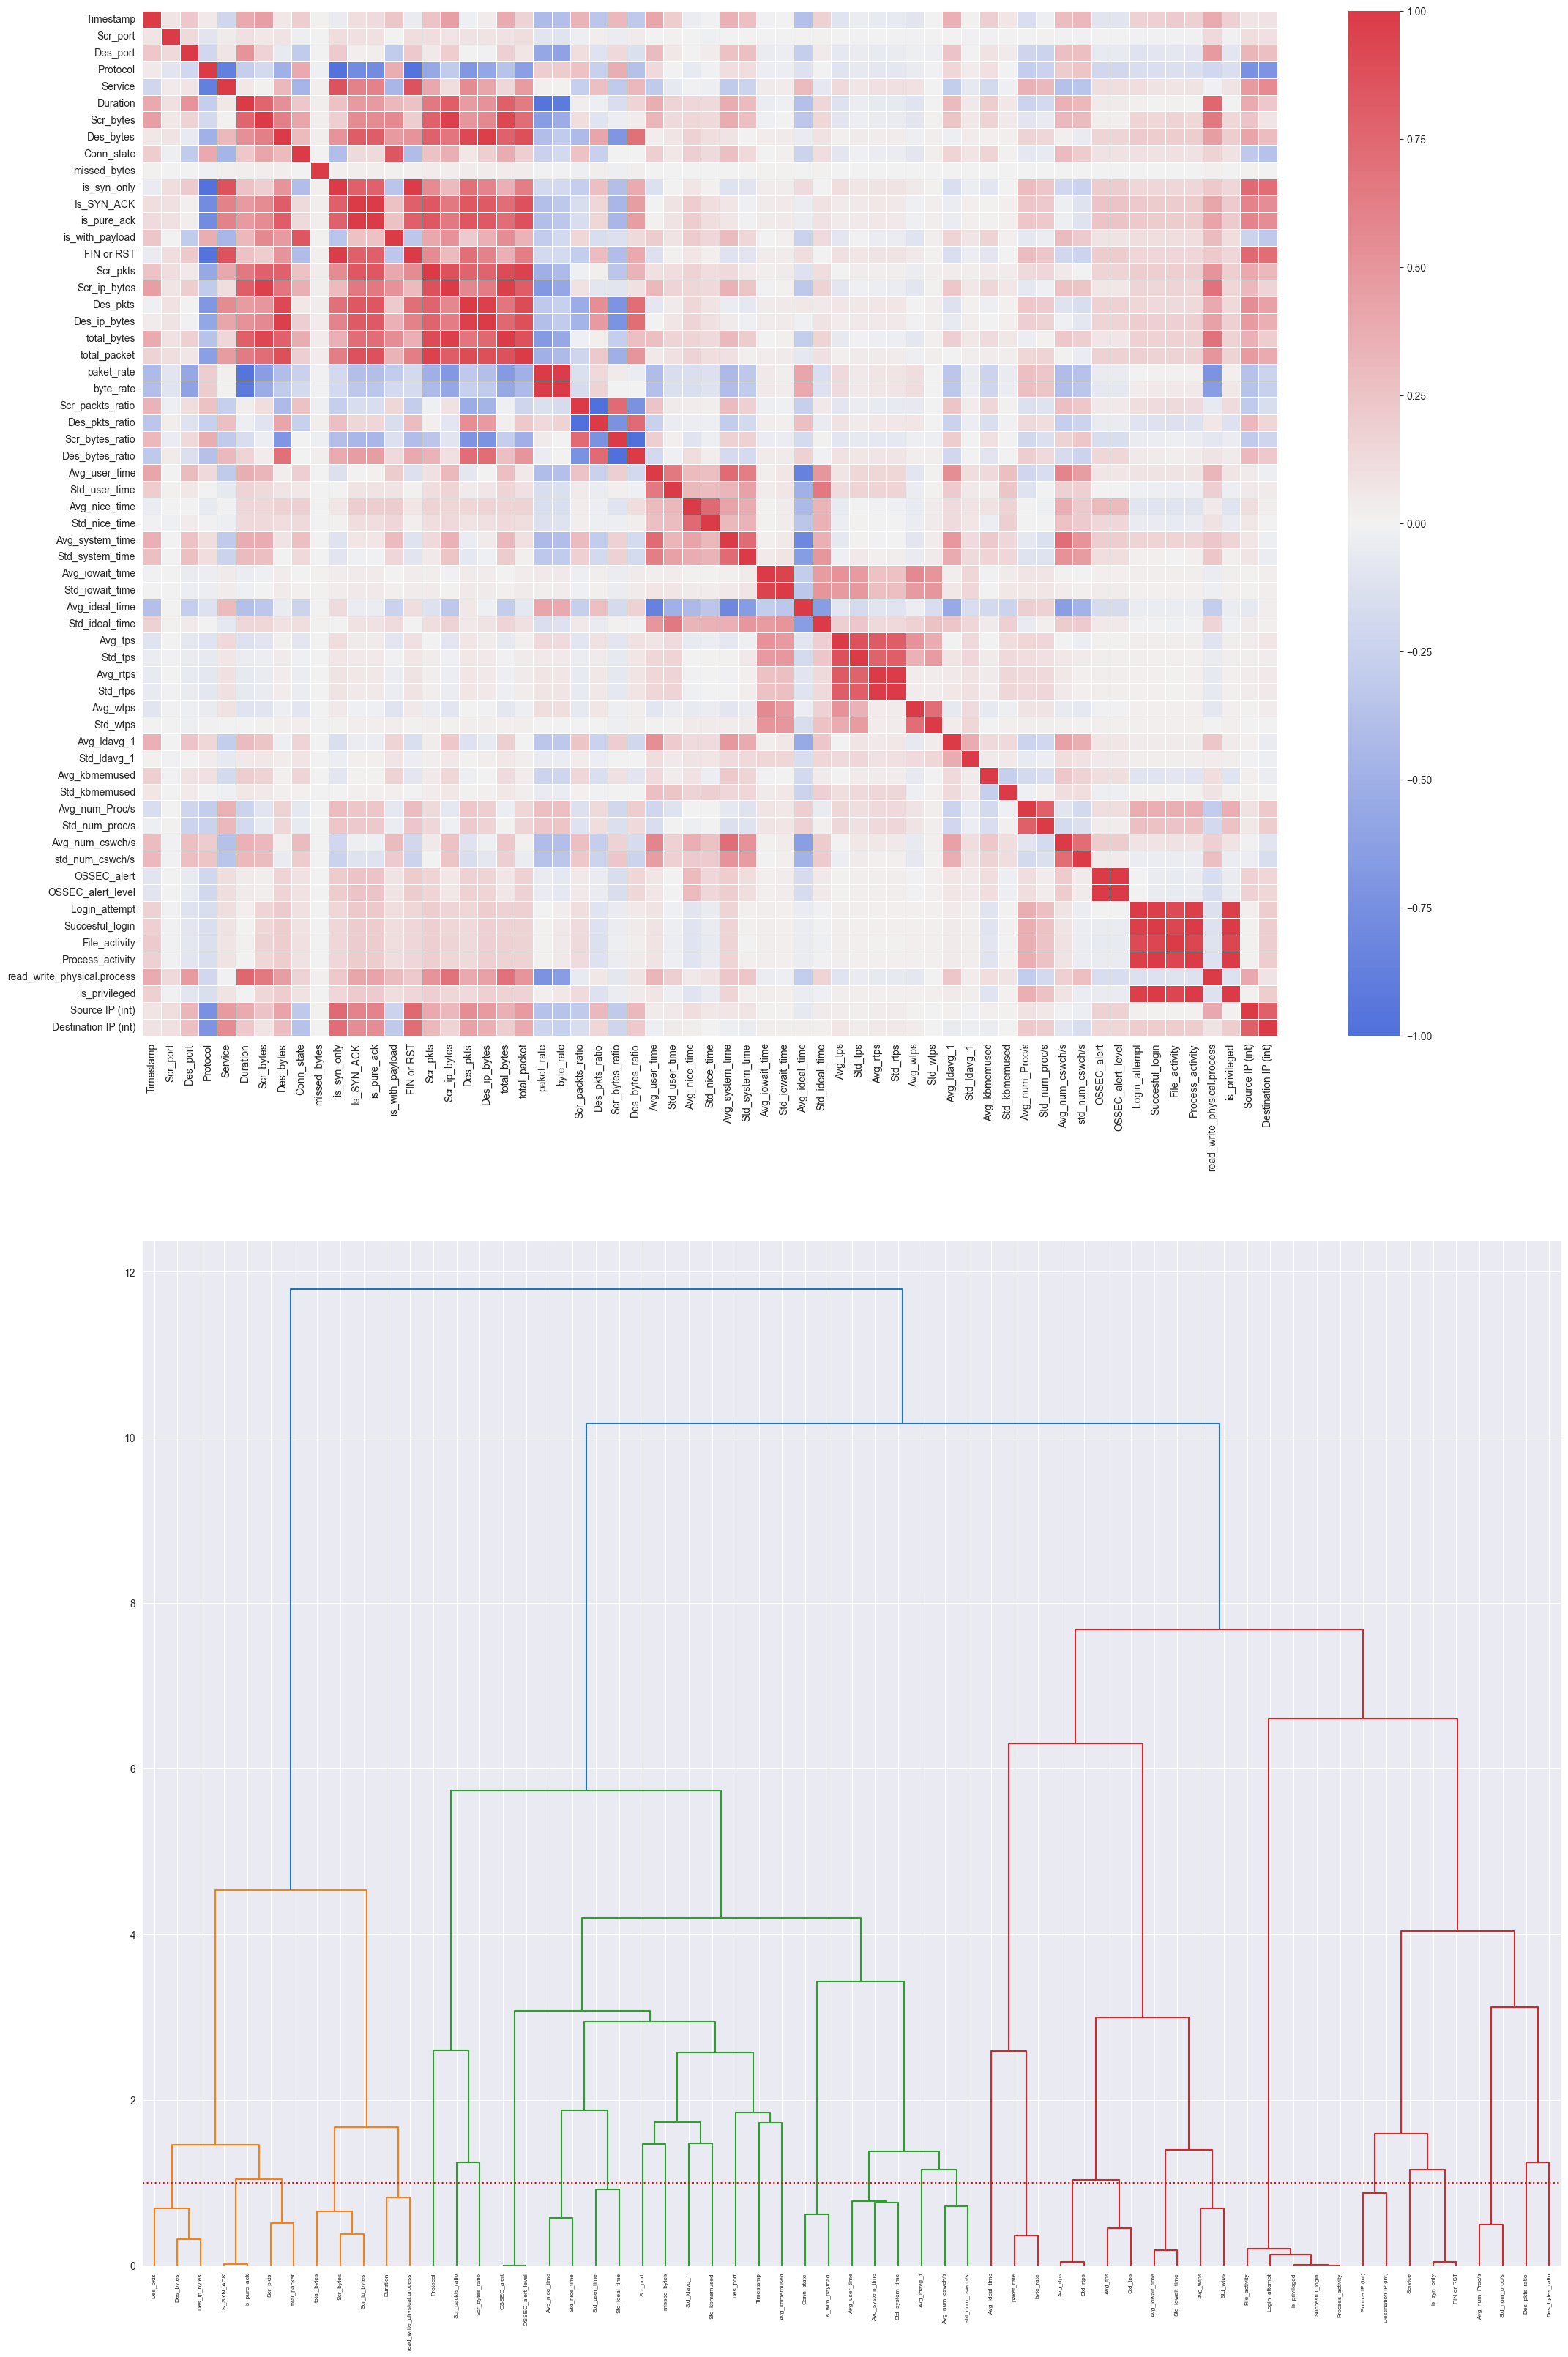

In [14]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

In [15]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0            Timestamp
1             Scr_port
2             Des_port
3             Protocol
4              Service
5             Duration
6            Scr_bytes
7            Des_bytes
8           Conn_state
9         missed_bytes
10         is_syn_only
11          Is_SYN_ACK
12            Scr_pkts
13          paket_rate
14    Scr_packts_ratio
15      Des_pkts_ratio
16     Scr_bytes_ratio
17     Des_bytes_ratio
18       Avg_user_time
19       Std_user_time
20       Avg_nice_time
21     Avg_iowait_time
22      Avg_ideal_time
23             Avg_tps
24            Avg_rtps
25            Avg_wtps
26         Avg_ldavg_1
27         Std_ldavg_1
28       Avg_kbmemused
29       Std_kbmemused
30      Avg_num_Proc/s
31     Avg_num_cswch/s
32         OSSEC_alert
33       Login_attempt
34     Source IP (int)
dtype: object

In [16]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 35


In [17]:
X

,Timestamp,Scr_port,Des_port,Protocol,Service,Duration,Scr_bytes,Des_bytes,Conn_state,missed_bytes,...,Avg_wtps,Avg_ldavg_1,Std_ldavg_1,Avg_kbmemused,Std_kbmemused,Avg_num_Proc/s,Avg_num_cswch/s,OSSEC_alert,Login_attempt,Source IP (int)
0,1.578541e+09,49278.0,80.0,1,4,0.673690,13437.0,34924.0,1,0.0,...,4.297,2.146,0.102781,915852.8,2507.975630,5.100,2806.200,1,0,3.232236e+09
1,1.578872e+09,39769.0,53.0,2,2,0.000083,78.0,0.0,1,0.0,...,6.600,0.612,0.037630,910498.4,4044.112046,1.000,1561.600,0,0,1.677724e+08
2,1.578522e+09,59050.0,53.0,2,2,0.000132,38.0,38.0,1,0.0,...,7.300,0.550,0.020000,921020.4,2139.652645,1.000,1603.300,0,0,2.887254e+09
3,1.582758e+09,37966.0,1880.0,1,16,9.378481,1121.0,484.0,1,0.0,...,5.700,0.708,0.026000,915874.8,977.885147,7.200,1685.300,0,1,3.232236e+09
5,1.580453e+09,50502.0,80.0,1,4,5.153928,460.0,671.0,1,0.0,...,10.500,0.524,0.028000,910370.8,4006.881700,0.900,1366.900,0,0,3.232238e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820827,1.579041e+09,51292.0,80.0,1,4,0.205832,127.0,310.0,1,0.0,...,8.403,1.647,0.050210,918959.6,1914.446510,0.900,2676.400,1,0,3.232236e+09
820830,1.579654e+09,45913.0,1880.0,1,16,63.290477,0.0,0.0,1,0.0,...,8.400,0.365,0.037749,917858.0,1713.499577,1.000,1456.400,0,0,2.887254e+09
820831,1.579064e+09,53252.0,80.0,1,4,14.787547,26091.0,604398.0,0,0.0,...,3.100,0.357,0.021000,913178.4,505.749978,0.600,1056.300,0,0,3.232238e+09
820832,1.578375e+09,44451.0,19315.0,1,11,0.000011,0.0,0.0,0,0.0,...,11.600,0.133,0.006403,910077.6,2716.049602,0.799,1168.365,0,0,3.232236e+09


<Axes: >

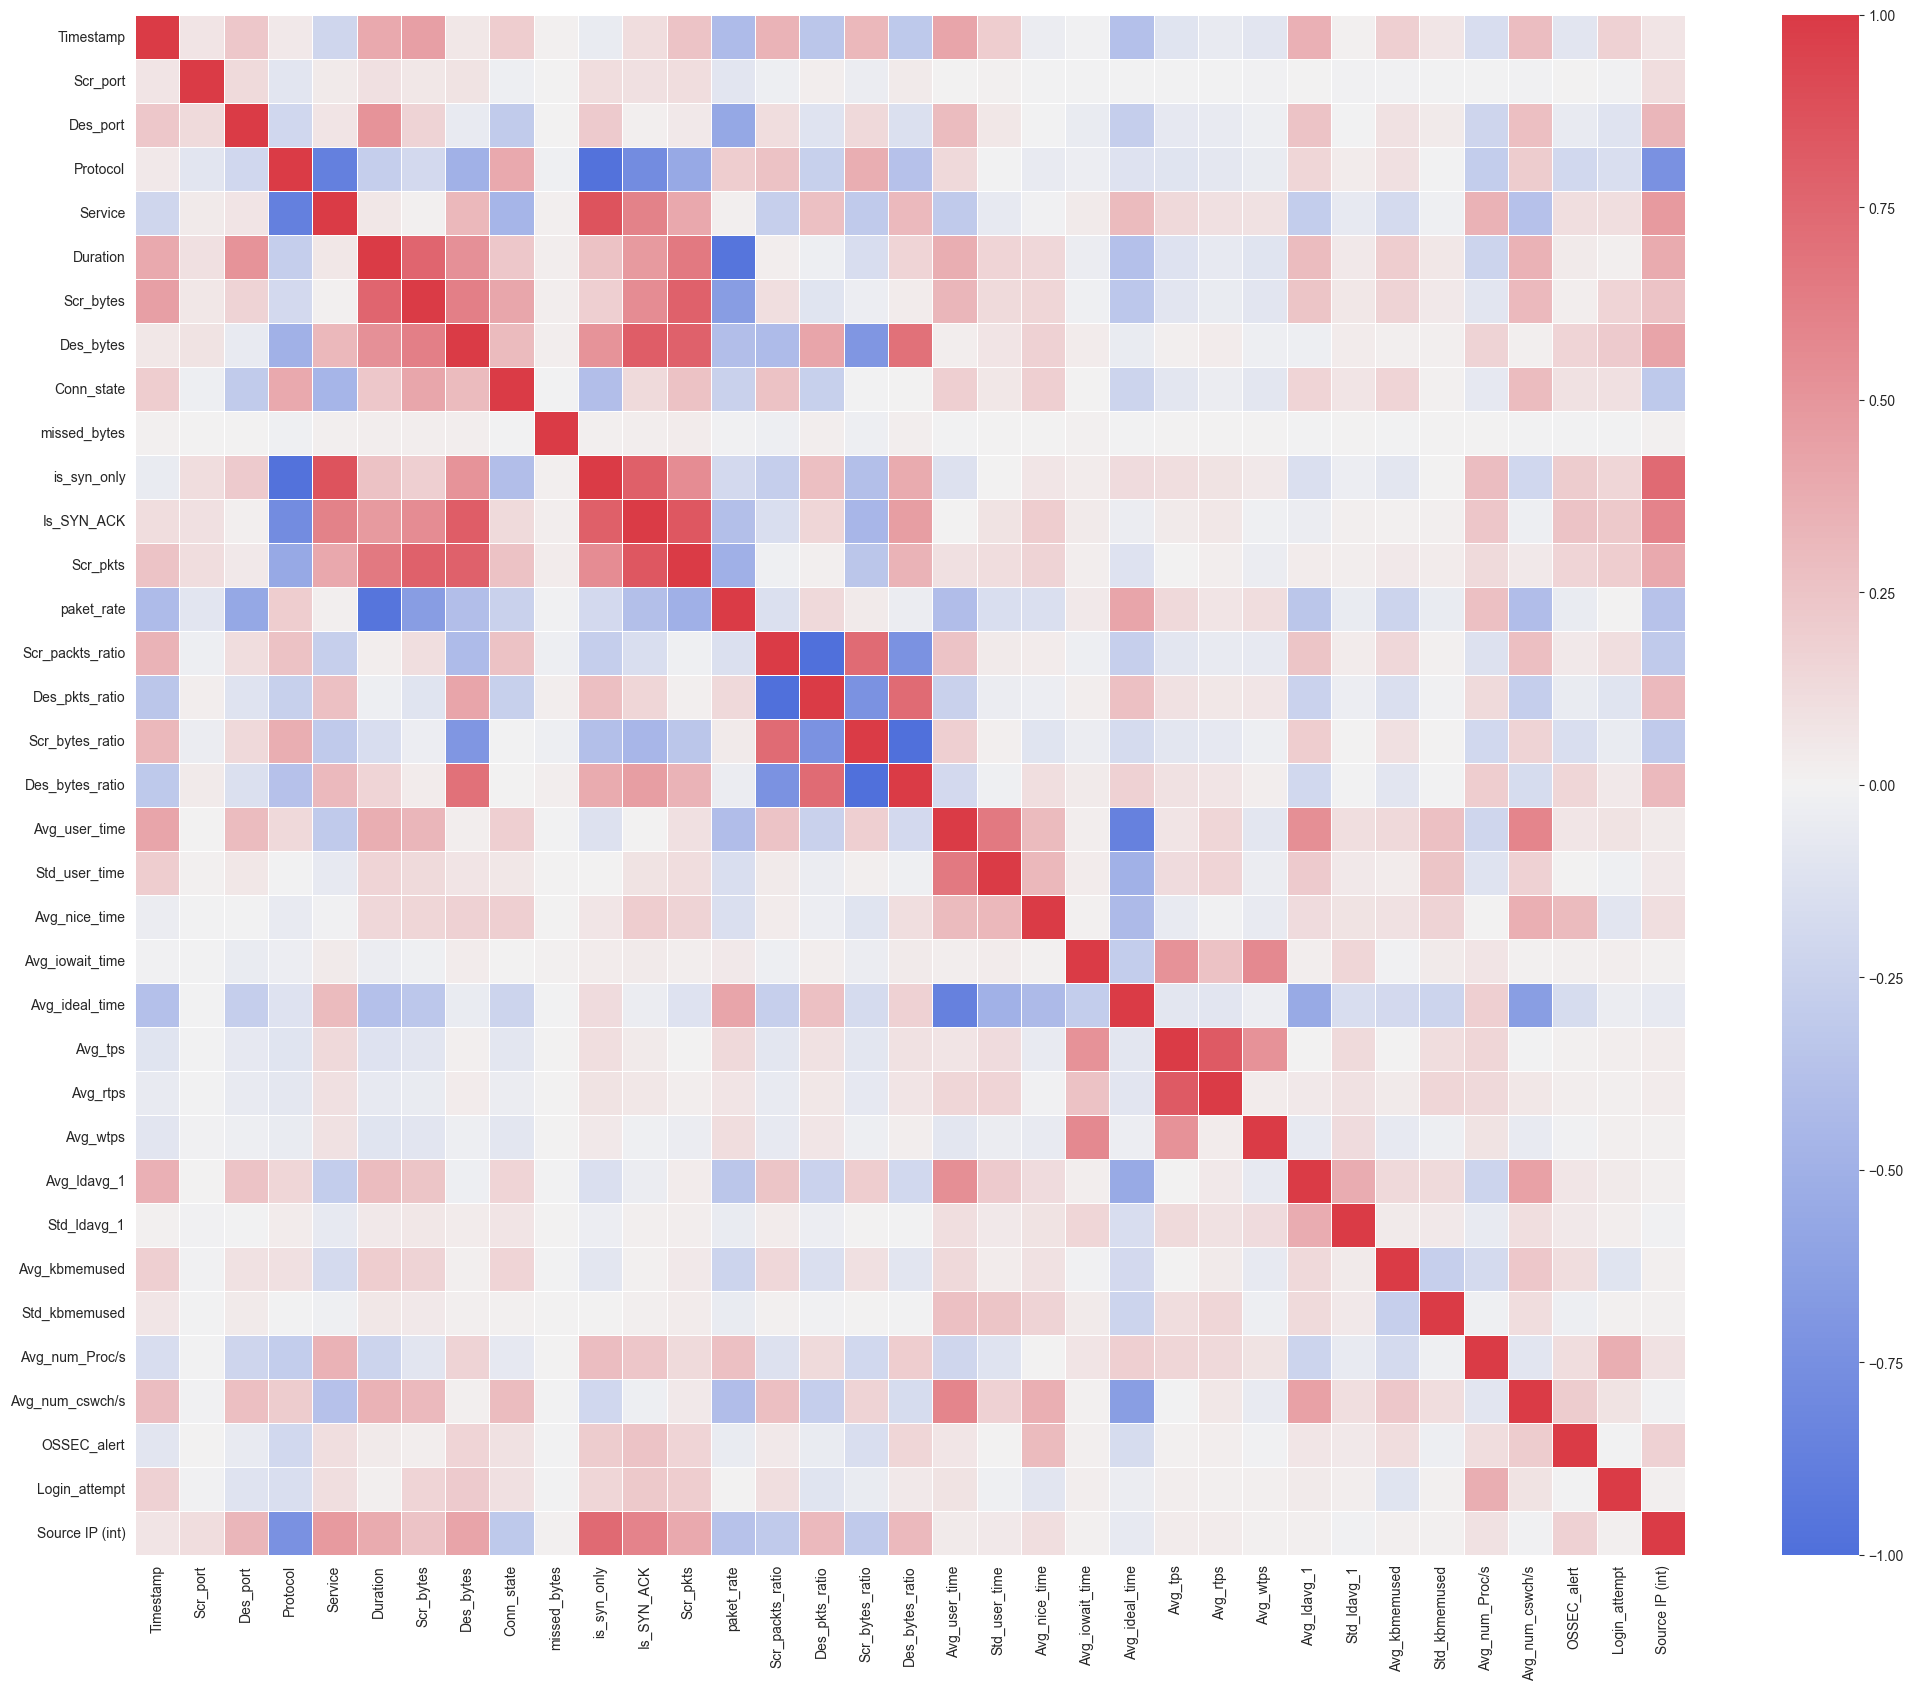

In [18]:
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))


test1

In [19]:
X.shape

(595628, 35)

In [20]:
y.shape

(595628, 1)

In [21]:
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)
print("Encoded y:", y)
print("Classes:", label_encoder_y.classes_)

Encoded y: [0 1 1 ... 1 0 1]
Classes: ['Attack' 'Normal']


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



In [52]:
unique_classes = np.unique(y_train)
class_weights = {cls: len(y_train) / np.sum(y_train == cls) for cls in unique_classes}
print(f"Class weights: {class_weights}")

Class weights: {0: 2.2960189655670877, 1: 1.7715936468278755}


In [53]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1300,
    learning_rate=0.2,
    depth=9,
    loss_function='MultiClass',
    task_type='GPU',
    verbose=20,
    random_seed=42,
    l2_leaf_reg=2,
    border_count=512,
    early_stopping_rounds=150,
    eval_metric='TotalF1',
    leaf_estimation_iterations=10,
    bagging_temperature=1.0,
    class_weights=list(class_weights.values()),
)

# Train the model
model.fit(X_train, y_train)


0:	learn: 0.9644975	total: 27.3ms	remaining: 35.5s
20:	learn: 0.9997398	total: 578ms	remaining: 35.2s
40:	learn: 0.9998468	total: 947ms	remaining: 29.1s
60:	learn: 0.9998867	total: 1.16s	remaining: 23.5s
80:	learn: 0.9999454	total: 1.85s	remaining: 27.8s
100:	learn: 0.9999748	total: 2.41s	remaining: 28.6s
120:	learn: 0.9999853	total: 3.16s	remaining: 30.8s
140:	learn: 0.9999916	total: 3.7s	remaining: 30.4s
160:	learn: 0.9999958	total: 4.44s	remaining: 31.4s
180:	learn: 0.9999958	total: 4.98s	remaining: 30.8s
200:	learn: 0.9999958	total: 5.72s	remaining: 31.3s
220:	learn: 0.9999979	total: 6.26s	remaining: 30.6s
240:	learn: 1.0000000	total: 6.93s	remaining: 30.4s
260:	learn: 1.0000000	total: 7.47s	remaining: 29.7s
280:	learn: 1.0000000	total: 7.98s	remaining: 28.9s
300:	learn: 1.0000000	total: 8.49s	remaining: 28.2s
320:	learn: 1.0000000	total: 9.01s	remaining: 27.5s
340:	learn: 1.0000000	total: 9.52s	remaining: 26.8s
360:	learn: 1.0000000	total: 10s	remaining: 26.1s
380:	learn: 1.000000

In [54]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.9998908718499739
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51884
           1       1.00      1.00      1.00     67242

    accuracy                           1.00    119126
   macro avg       1.00      1.00      1.00    119126
weighted avg       1.00      1.00      1.00    119126



Accuracy: 0.999891
Classification Report:
               precision    recall  f1-score   support

           0   0.999904  0.999846  0.999875     51884
           1   0.999881  0.999926  0.999903     67242

    accuracy                       0.999891    119126
   macro avg   0.999892  0.999886  0.999889    119126
weighted avg   0.999891  0.999891  0.999891    119126



<Figure size 800x600 with 0 Axes>

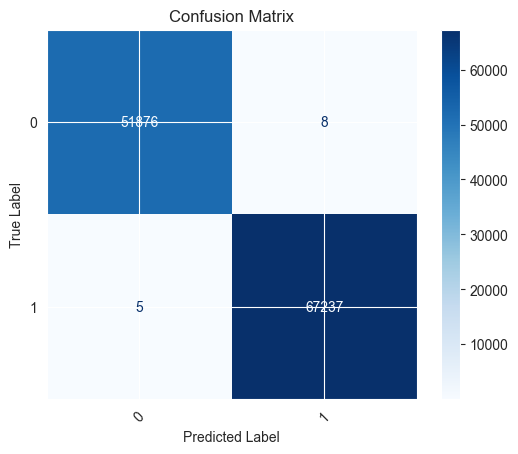

In [55]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

classification_report_str = classification_report(y_test, y_pred, digits=6)
print("Classification Report:\n", classification_report_str)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='.6g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [62]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
# Assuming you have your data in a pandas DataFrame called 'df'
# X is your feature matrix, y is your target labels
# Example data, replace with your actual data loading

# Convert labels to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Initialize CatBoostClassifier with your specified parameters
model = CatBoostClassifier(
    iterations=1300,
    learning_rate=0.2,
    depth=9,
    loss_function='MultiClass',
    task_type='GPU',
    verbose=0,
    random_seed=42,
    l2_leaf_reg=2,
    border_count=512,
    early_stopping_rounds=150,
    eval_metric='TotalF1',
    leaf_estimation_iterations=10,
    bagging_temperature=1.0
)

# Set up stratified k-fold cross-validation (k=5)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions = []
all_recalls = []
all_f1s = []

# Perform stratified k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Split the data into training and test sets for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reset index for y_train and y_test:
    y_train = y_train
    y_test = y_test


    # Train the model
    model.fit(X_train, y_train, verbose=0)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics for the fold
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred,zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)


mean_precision = np.mean(all_precisions)
mean_recall = np.mean(all_recalls)
mean_f1 = np.mean(all_f1s)

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")



y_pred_all_training_set = model.predict_proba(X)

print(y_pred_all_training_set)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mean Precision: 0.9999
Mean Recall: 0.9999
Mean F1-Score: 0.9999
[[9.99997964e-01 2.03590320e-06]
 [2.09900432e-09 9.99999998e-01]
 [6.04286285e-06 9.99993957e-01]
 ...
 [3.97516692e-07 9.99999602e-01]
 [9.99999993e-01 7.01079939e-09]
 [6.85251744e-10 9.99999999e-01]]
